In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler
#!pip install tensorflow==2.12.0
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import (confusion_matrix, classification_report, roc_curve, auc)


In [37]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [38]:
df_all = df = pd.read_csv(r"/content/drive/MyDrive/Battery data/full_battery_data.csv")

In [39]:
df_all.head()

,Time,Voltage,Current,Temperature,SOC,DriveCycle,TemperatureLabel
0,0.0,4.175155,-3.691549e-06,15.96381,1.0,PDTCB,15
1,0.1,4.175155,-9.512327e-07,15.96381,1.0,PDTCB,15
2,0.2,4.174967,-4.821614e-07,15.96381,1.0,PDTCB,15
3,0.3,4.175153,-2.413463e-07,15.96381,1.0,PDTCB,15
4,0.4,4.174966,-8.059866e-08,15.96381,1.0,PDTCB,15


In [40]:
df_all.tail()

,Time,Voltage,Current,Temperature,SOC,DriveCycle,TemperatureLabel
9047242,11025.7,2.656538,-3.350742,8.943850,0.125165,US06,5
9047243,11025.8,2.655582,-3.351976,8.943850,0.125146,US06,5
9047244,11025.9,2.654630,-3.353234,8.945311,0.125128,US06,5
9047245,11026.0,2.653594,-3.354528,8.947360,0.125109,US06,5
9047246,11026.1,2.450127,-9.408817,8.947360,0.125090,US06,5


In [41]:
# --- Load and Normalize Data ---
sequence_df = df_all[['Voltage', 'Current', 'Temperature', 'SOC']].copy()

scaler = MinMaxScaler()
sequence_df[:] = scaler.fit_transform(sequence_df)

# --- Create Sequences ---
def create_sequences(data, sequence_length=20):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i + sequence_length, :-1])  # 3 features
        y.append(data[i + sequence_length, -1])     # SOC target
    return np.array(X), np.array(y)

data_np = sequence_df.to_numpy()
X_lstm, y_lstm = create_sequences(data_np, sequence_length=20)



In [42]:
# --- Train/Test Split: 80% train, 20% test ---
X_train_lstm, X_test_lstm, y_train_lstm, y_test_lstm = train_test_split(
    X_lstm, y_lstm, test_size=0.2, random_state=42, shuffle=True
)

In [43]:
# --- Build Model ---
model = Sequential()
model.add(LSTM(64, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2]), return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [44]:
# --- Train ---
history = model.fit(
    X_train_lstm, y_train_lstm,
    validation_data=(X_test_lstm, y_test_lstm),
    epochs=30,
    batch_size=64,
    verbose=1
)

Epoch 1/30
113091/113091 ━━━━━━━━━━━━━━━━━━━━ 528s 5ms/step - loss: 0.0013 - val_loss: 3.0121e-04
Epoch 2/30
113091/113091 ━━━━━━━━━━━━━━━━━━━━ 527s 5ms/step - loss: 6.2145e-04 - val_loss: 2.8518e-04
Epoch 3/30
113091/113091 ━━━━━━━━━━━━━━━━━━━━ 527s 5ms/step - loss: 5.9613e-04 - val_loss: 2.9307e-04
Epoch 4/30
113091/113091 ━━━━━━━━━━━━━━━━━━━━ 528s 5ms/step - loss: 5.8323e-04 - val_loss: 2.7535e-04
Epoch 5/30
113091/113091 ━━━━━━━━━━━━━━━━━━━━ 528s 5ms/step - loss: 5.7582e-04 - val_loss: 2.6763e-04
Epoch 6/30
113091/113091 ━━━━━━━━━━━━━━━━━━━━ 530s 5ms/step - loss: 5.7125e-04 - val_loss: 2.7118e-04
Epoch 7/30
113091/113091 ━━━━━━━━━━━━━━━━━━━━ 531s 5ms/step - loss: 5.6507e-04 - val_loss: 2.7576e-04
Epoch 8/30
113091/113091 ━━━━━━━━━━━━━━━━━━━━ 530s 5ms/step - loss: 5.6139e-04 - val_loss: 2.6017e-04
Epoch 9/30
113091/113091 ━━━━━━━━━━━━━━━━━━━━ 529s 5ms/step - loss: 5.5580e-04 - val_loss: 2.5992e-04
Epoch 10/30
113091/113091 ━━━━━━━━━━━━━━━━━━━━ 528s 5ms/step - loss: 5.5170e-04 - val_

In [50]:
# --- Predict & Evaluate ---
y_pred_lstm = model.predict(X_test_lstm).flatten()
rmse = np.sqrt(mean_squared_error(y_test_lstm, y_pred_lstm))
r2 = r2_score(y_test_lstm, y_pred_lstm)

print("LSTM RMSE:", rmse)
print("LSTM R²:", r2)

56546/56546 ━━━━━━━━━━━━━━━━━━━━ 80s 1ms/step
LSTM RMSE: 0.013154013156851344
LSTM R²: 0.997657097139121


In [51]:
rmse = np.sqrt(mean_squared_error(y_test_lstm, y_pred_lstm))
mae = mean_absolute_error(y_test_lstm, y_pred_lstm)
r2 = r2_score(y_test_lstm, y_pred_lstm)

In [52]:
print(f"Test R²: {r2:.3f}")
print(f"Test RMSE: {rmse:.3f}")
print(f"Test MAE: {mae:.3f}")

Test R²: 0.998
Test RMSE: 0.013
Test MAE: 0.009


In [53]:
# Save model
model.save("lstm_soc_model.h5")
model.save("lstm_soc_model.keras")
print("✅ Model saved as lstm_soc_model.h5")


✅ Model saved as lstm_soc_model.h5


In [48]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.preprocessing import KBinsDiscretizer
from tensorflow.keras.utils import to_categorical

# Step 1: Define number of bins for classification
n_bins = 10  # You can choose 5, 10, etc.

# Step 2: Bin SOC into discrete classes using KBinsDiscretizer
discretizer = KBinsDiscretizer(n_bins=n_bins, encode='ordinal', strategy='uniform')
y_test_cls = discretizer.fit_transform(y_test_lstm.reshape(-1, 1)).astype(int).flatten()
y_pred_cls = discretizer.transform(y_pred_lstm.reshape(-1, 1)).astype(int).flatten()

# Step 3: Compute classification metrics
accuracy = accuracy_score(y_test_cls, y_pred_cls)
f1 = f1_score(y_test_cls, y_pred_cls, average='macro')  # macro = class-agnostic average
y_test_onehot = to_categorical(y_test_cls, num_classes=n_bins)
y_pred_onehot = to_categorical(y_pred_cls, num_classes=n_bins)

# Step 4: Calculate AUC using one-vs-rest
try:
    auc = roc_auc_score(y_test_onehot, y_pred_onehot, multi_class='ovr')
except ValueError:
    auc = None  # In case some bins are missing

# Step 5: Print results in your format
epochs = 10  # change to your actual training epoch count
print(f"Test: Epoch {epochs}")
print(f"Test ACC: {accuracy:.3f}")
print(f"Test F1: {f1:.3f}")
print(f"Test AUC: {auc:.3f}" if auc is not None else "Test AUC: N/A (insufficient class coverage)")


Test: Epoch 10
Test ACC: 0.921
Test F1: 0.924
Test AUC: 0.957


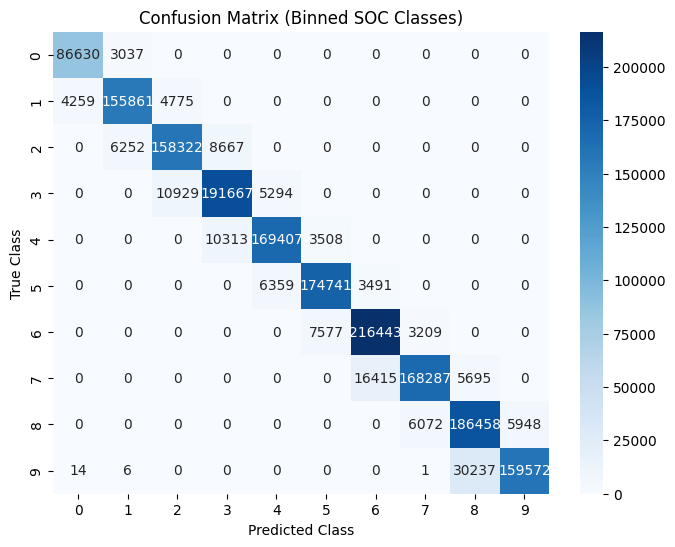

Classification Report:

              precision    recall  f1-score   support

     Class 0       0.95      0.97      0.96     89667
     Class 1       0.94      0.95      0.94    164895
     Class 2       0.91      0.91      0.91    173241
     Class 3       0.91      0.92      0.92    207890
     Class 4       0.94      0.92      0.93    183228
     Class 5       0.94      0.95      0.94    184591
     Class 6       0.92      0.95      0.93    227229
     Class 7       0.95      0.88      0.91    190397
     Class 8       0.84      0.94      0.89    198478
     Class 9       0.96      0.84      0.90    189830

    accuracy                           0.92   1809446
   macro avg       0.93      0.92      0.92   1809446
weighted avg       0.92      0.92      0.92   1809446



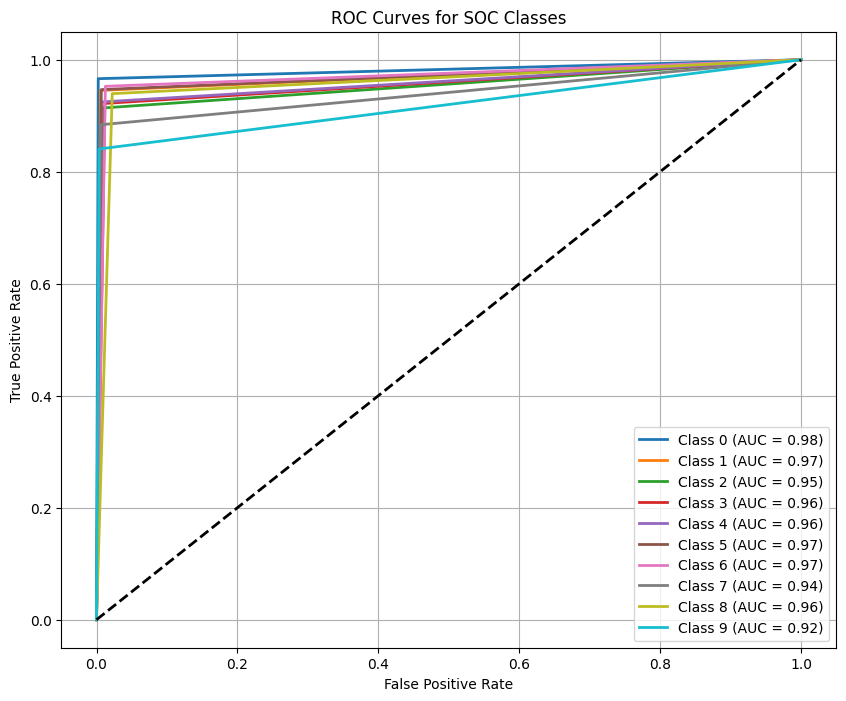

In [49]:
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

# Confusion Matrix
conf_matrix = confusion_matrix(y_test_cls, y_pred_cls)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=range(n_bins), yticklabels=range(n_bins))
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.title('Confusion Matrix (Binned SOC Classes)')
plt.show()

# Per-Class Accuracy and F1 Score
print("Classification Report:\n")
print(classification_report(y_test_cls, y_pred_cls, target_names=[f'Class {i}' for i in range(n_bins)]))

# ROC Curves for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

plt.figure(figsize=(10, 8))
for i in range(n_bins):
    fpr[i], tpr[i], _ = roc_curve(y_test_onehot[:, i], y_pred_onehot[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], lw=2, label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for SOC Classes')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


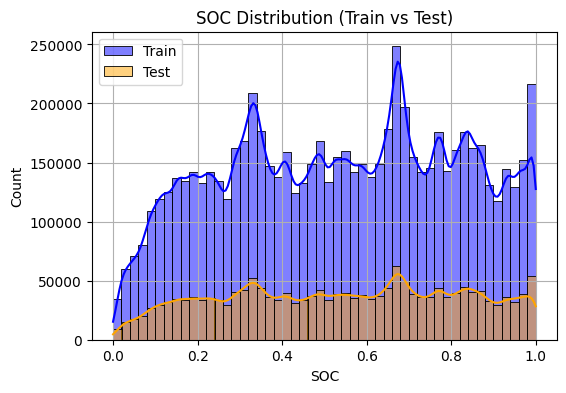

In [54]:
plt.figure(figsize=(6,4))
sns.histplot(y_train_lstm, color='blue', label='Train', kde=True, bins=50)
sns.histplot(y_test_lstm, color='orange', label='Test', kde=True, bins=50)
plt.title("SOC Distribution (Train vs Test)")
plt.xlabel("SOC")
plt.ylabel("Count")
plt.legend()
plt.grid(True)
plt.show()

In [55]:
# -----------------------------
# 2. Sequence Length Check
# -----------------------------
print(f"Train shape: {X_train_lstm.shape} → sequences: {X_train_lstm.shape[0]}, timesteps: {X_train_lstm.shape[1]}, features: {X_train_lstm.shape[2]}")
print(f"Test shape:  {X_test_lstm.shape} → sequences: {X_test_lstm.shape[0]}, timesteps: {X_test_lstm.shape[1]}, features: {X_test_lstm.shape[2]}")


Train shape: (7237781, 20, 3) → sequences: 7237781, timesteps: 20, features: 3
Test shape:  (1809446, 20, 3) → sequences: 1809446, timesteps: 20, features: 3


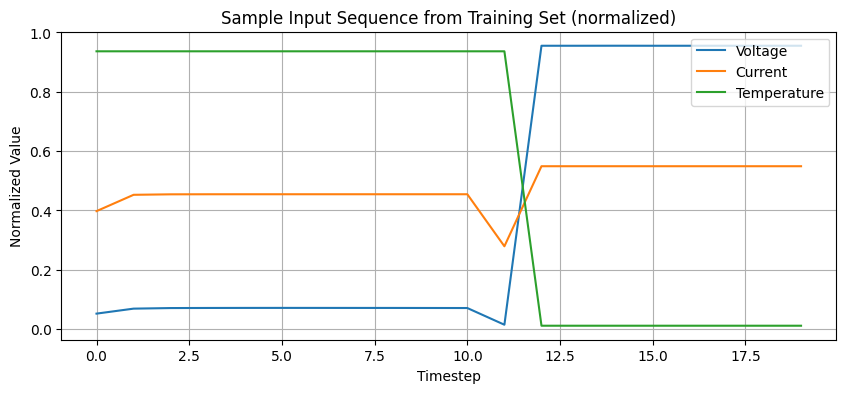

In [56]:
# -----------------------------
# 3. Sample Sequence Visualization (first from train)
# -----------------------------
sample_idx = 0
sample_sequence = X_train_lstm[sample_idx]

plt.figure(figsize=(10,4))
plt.plot(sample_sequence[:, 0], label='Voltage')
plt.plot(sample_sequence[:, 1], label='Current')
plt.plot(sample_sequence[:, 2], label='Temperature')
plt.title("Sample Input Sequence from Training Set (normalized)")
plt.xlabel("Timestep")
plt.ylabel("Normalized Value")
plt.legend()
plt.grid(True)
plt.show()


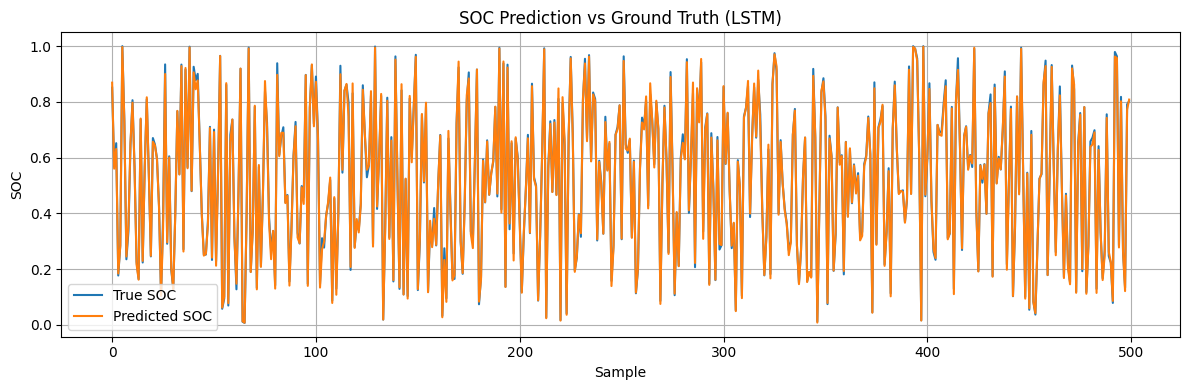

In [60]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.plot(y_test_lstm[:500], label='True SOC')
plt.plot(y_pred_lstm[:500], label='Predicted SOC')
plt.xlabel("Sample")
plt.ylabel("SOC")
plt.title("SOC Prediction vs Ground Truth (LSTM)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


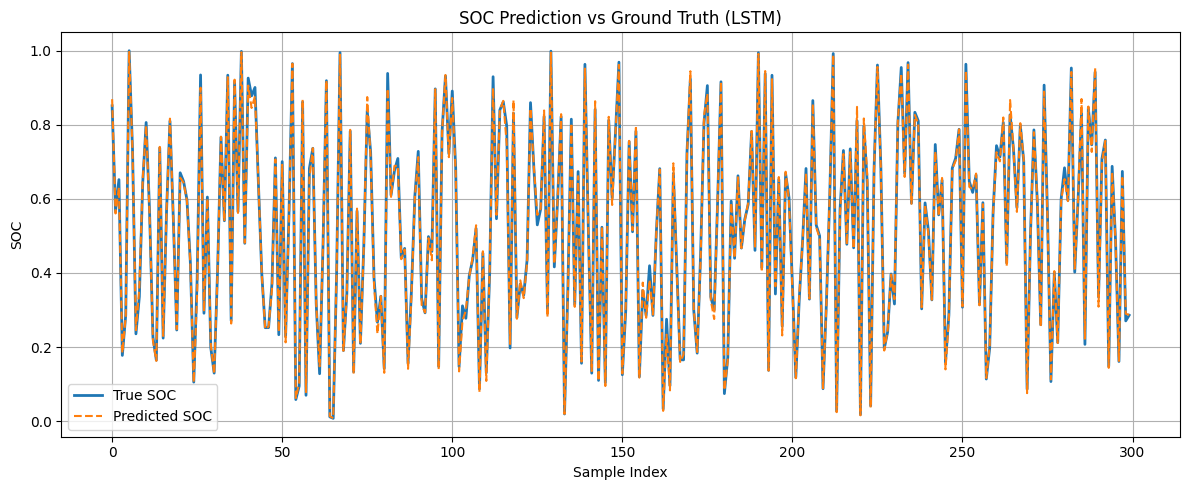

In [62]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.plot(y_test_lstm[:300], label='True SOC', linewidth=2)
plt.plot(y_pred_lstm[:300], label='Predicted SOC', linestyle='--')
plt.title("SOC Prediction vs Ground Truth (LSTM)")
plt.xlabel("Sample Index")
plt.ylabel("SOC")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


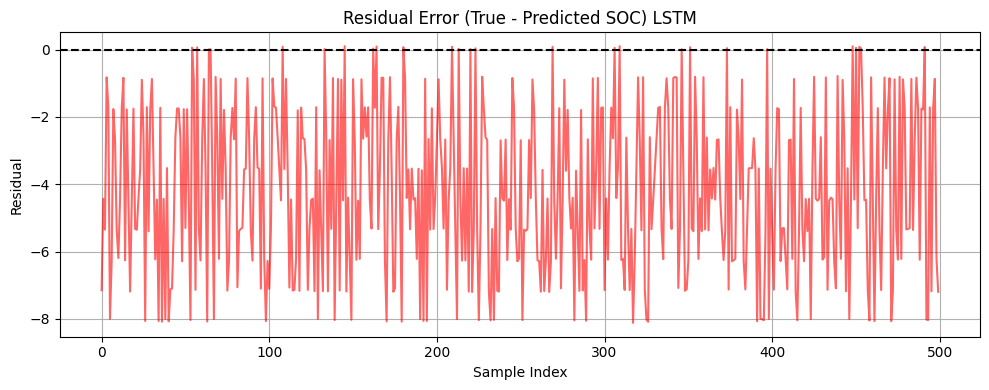

In [65]:
residuals = y_test_lstm - y_pred_cls

plt.figure(figsize=(10, 4))
plt.plot(residuals[:500], color='red', alpha=0.6)
plt.axhline(0, color='black', linestyle='--')
plt.title("Residual Error (True - Predicted SOC) LSTM")
plt.xlabel("Sample Index")
plt.ylabel("Residual")
plt.grid(True)
plt.tight_layout()
plt.show()


/tmp/ipython-input-66-1870316518.py:9: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()


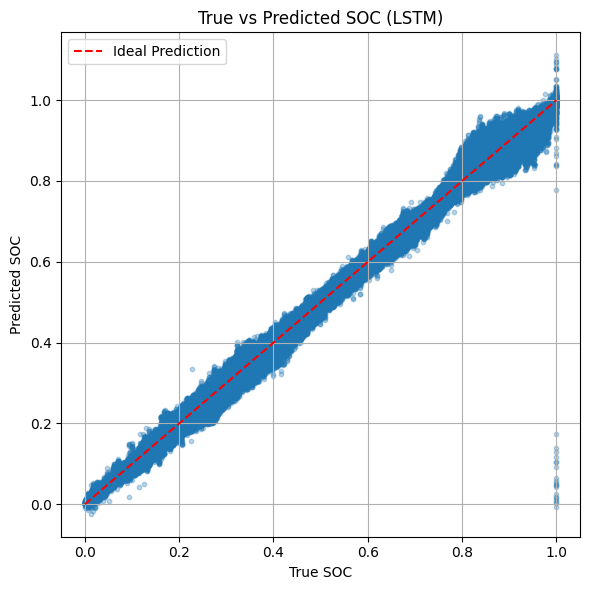

In [66]:
plt.figure(figsize=(6, 6))
plt.scatter(y_test_lstm, y_pred_lstm, alpha=0.3, s=10)
plt.plot([0, 1], [0, 1], 'r--', label='Ideal Prediction')
plt.xlabel("True SOC")
plt.ylabel("Predicted SOC")
plt.title("True vs Predicted SOC (LSTM)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


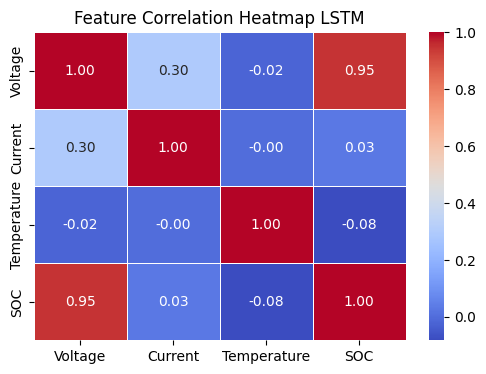

In [67]:
# Compute correlation matrix
correlation_matrix = df_all[['Voltage', 'Current', 'Temperature', 'SOC']].corr()

# Plot heatmap
plt.figure(figsize=(6,4))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Feature Correlation Heatmap LSTM")
plt.show()


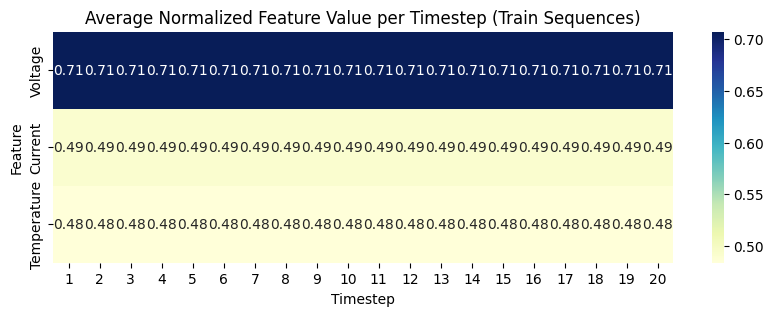

In [68]:
# Average across all sequences in training set
feature_means = X_train_lstm.mean(axis=0).T  # shape: (features, timesteps)

# Plot heatmap
plt.figure(figsize=(10,3))
sns.heatmap(feature_means, cmap="YlGnBu", xticklabels=range(1, 21), yticklabels=['Voltage', 'Current', 'Temperature'], annot=True, fmt=".2f")
plt.title("Average Normalized Feature Value per Timestep (Train Sequences)")
plt.xlabel("Timestep")
plt.ylabel("Feature")
plt.show()


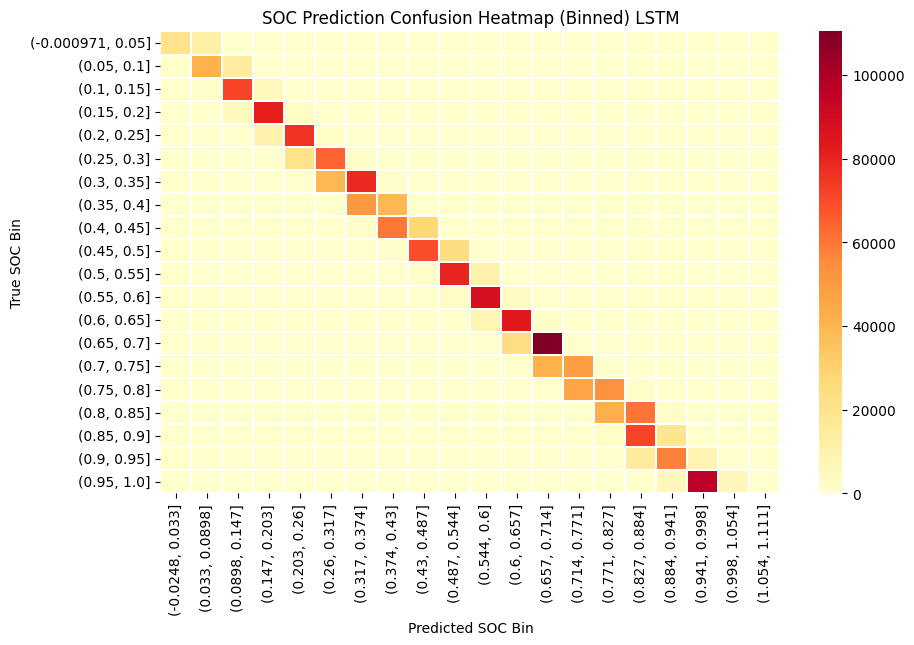

In [71]:
import pandas as pd

# Bin values into 20 bins
df_pred = pd.DataFrame({'y_true': y_test_lstm, 'y_pred': y_pred_lstm})
df_pred['y_true_bin'] = pd.cut(df_pred['y_true'], bins=20)
df_pred['y_pred_bin'] = pd.cut(df_pred['y_pred'], bins=20)

heatmap_data = pd.crosstab(df_pred['y_true_bin'], df_pred['y_pred_bin'])

plt.figure(figsize=(10,6))
sns.heatmap(heatmap_data, cmap="YlOrRd", linewidths=0.1)
plt.title("SOC Prediction Confusion Heatmap (Binned) LSTM")
plt.xlabel("Predicted SOC Bin")
plt.ylabel("True SOC Bin")
plt.show()


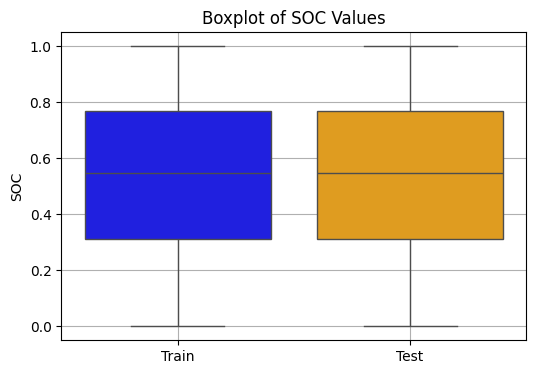

In [58]:
# -----------------------------
# 5. Boxplot of SOC
# -----------------------------
plt.figure(figsize=(6,4))
sns.boxplot(data=[y_train_lstm, y_test_lstm], palette=["blue", "orange"])
plt.xticks([0, 1], ['Train', 'Test'])
plt.ylabel("SOC")
plt.title("Boxplot of SOC Values")
plt.grid(True)
plt.show()

In [73]:
from collections import deque
import numpy as np

# Buffer of last 20 steps (Voltage, Current, Temperature)
sequence_buffer = deque(maxlen=20)

# Example: Start with a few historical values (this is needed)
initial_history = df_all[['Voltage', 'Current', 'Temperature']].iloc[:20].values
for row in initial_history:
    sequence_buffer.append(row)


In [74]:
def predict_soc_realtime(new_reading, model, scaler, sequence_buffer):
    """
    new_reading: dict with keys 'Voltage', 'Current', 'Temperature'
    model: trained LSTM model
    scaler: fitted MinMaxScaler
    sequence_buffer: deque with 20 previous [V, C, T] values
    """

    # Append new reading to buffer
    input_row = np.array([[new_reading['Voltage'], new_reading['Current'], new_reading['Temperature'], 0]])  # Dummy SOC
    input_row_scaled = scaler.transform(input_row)[:, :-1]  # remove SOC after scaling
    sequence_buffer.append(input_row_scaled.flatten())

    # Only predict if we have full 20-step history
    if len(sequence_buffer) < 20:
        print("⚠️ Not enough data for prediction yet.")
        return None

    # Prepare input for model: shape (1, 20, 3)
    input_sequence = np.array(sequence_buffer).reshape(1, 20, 3)

    # Predict
    predicted_soc = model.predict(input_sequence).flatten()[0]
    return predicted_soc


In [94]:
new_input = {
    'Voltage': 4.175155,
    'Current': 0.000003691549,
    'Temperature': 15.1
}

predicted_soc = predict_soc_realtime(new_input, model, scaler, sequence_buffer)
if predicted_soc is not None:
    print(f"🔋 Predicted SOC: {predicted_soc:.5f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
🔋 Predicted SOC: 0.92438


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


In [154]:
import numpy as np

# Example: new input values (replace with your actual values)
new_input = {
    'Voltage': 4.1,
    'Current': 0.8,
    'Temperature': 35
}

input_array = np.array([[new_input['Voltage'], new_input['Current'], new_input['Temperature']]])

input_for_model = input_array.reshape((1, 1, 3))  # adjust shape if necessary

# Predict SOC
predicted_soc = model.predict(input_for_model)
predicted_soc = np.clip(predicted_soc, 0, 1)

print(f"Predicted SOC: {predicted_soc.flatten()[0]:.5f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Predicted SOC: 0.73807


In [143]:
print("Voltage min/max:", scaler.data_min_[0], scaler.data_max_[0])
print("Current min/max:", scaler.data_min_[1], scaler.data_max_[1])
print("Temp min/max:", scaler.data_min_[2], scaler.data_max_[2])
print("SOC min/max:", scaler.data_min_[3], scaler.data_max_[3])


Voltage min/max: 2.425913069137115 4.248281199698924
Current min/max: -10.263029782514211 8.42701616078839
Temp min/max: 5.4421 50.32433
SOC min/max: 0.0252514785427041 1.0


In [155]:
realistic_input = [4.1, 0.8, 35.0]

# Repeat for 20 steps (for LSTM)
sequence_raw = np.array([realistic_input] * 20)

# Follow same prediction process
dummy_soc = np.zeros((20, 1))
sequence_with_soc = np.hstack([sequence_raw, dummy_soc])
sequence_scaled = scaler.transform(sequence_with_soc)
sequence_scaled_input = sequence_scaled[:, :-1]
input_for_model = sequence_scaled_input.reshape(1, 20, 3)

# Predict
predicted_soc_normalized = model.predict(input_for_model)[0][0]
soc_min = scaler.data_min_[-1]
soc_max = scaler.data_max_[-1]
predicted_soc = soc_min + predicted_soc_normalized * (soc_max - soc_min)

# Output
print(f"✅ Predicted SOC (safe input): {predicted_soc:.5f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
✅ Predicted SOC (safe input): 0.86979


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


In [158]:
import numpy as np

# Your 20 rows of raw input data (Voltage, Current, Temperature)
input_data = np.array([
    [4.1, 0.8, 35.0],
    [4.09, 0.79, 34.9],
    [4.08, 0.78, 34.8],
    [4.07, 0.77, 34.8],
    [4.06, 0.76, 33.7],
    [4.05, 0.75, 33.6],
    [4.04, 0.74, 33.5],
    [4.03, 0.73, 33.5],
    [4.02, 0.72, 33.4],
    [4.01, 0.71, 33.3],
    [4.00, 0.70, 33.3],
    [3.99, 0.69, 33.2],
    [3.98, 0.68, 34.1],
    [3.97, 0.67, 33.1],
    [3.96, 0.66, 33.0],
    [3.95, 0.65, 34.0],
    [3.94, 0.64, 34.9],
    [3.93, 0.63, 33.8],
    [3.92, 0.62, 33.8],
    [3.91, 0.61, 33.7],
])  # shape: (20, 3)

# Add dummy SOC column (zeros) because scaler expects 4 columns
dummy_soc = np.zeros((20, 1))
input_with_soc = np.hstack([input_data, dummy_soc])  # shape: (20, 4)

# Normalize input
input_scaled = scaler.transform(input_with_soc)

# Remove SOC column before feeding to model
input_scaled_features = input_scaled[:, :-1]

# Reshape for LSTM: (1, 20, 3)
input_for_model = input_scaled_features.reshape(1, 20, 3)

# Predict normalized SOC
predicted_soc_norm = model.predict(input_for_model)[0][0]

# Denormalize SOC
soc_min = scaler.data_min_[-1]
soc_max = scaler.data_max_[-1]
predicted_soc = soc_min + predicted_soc_norm * (soc_max - soc_min)

print(f"🔋 Predicted SOC: {predicted_soc:.5f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
🔋 Predicted SOC: 0.67588


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
